In [36]:
import torch 
import torch.nn as nn 
import numpy as np 
import cv2
import matplotlib.pyplot as plt 
import torchinfo 

## Convolutional patching 
input shape: (224, 224, 1) => (196, 1, 16, 16) 

In [2]:
height = 224
width = 224
color_channels = 1
patch_size = 16 

num_of_patches = (height * width) // (patch_size * patch_size)
num_of_patches

# embedding dimension D (a flattend patch)
embedding_dimension = patch_size * patch_size * color_channels

### PATCH EMBEDDING

In [3]:
# embedding layer output shape: 
embedding_layer_output_shape = (num_of_patches, patch_size * patch_size * color_channels) 
embedding_layer_output_shape

(196, 256)

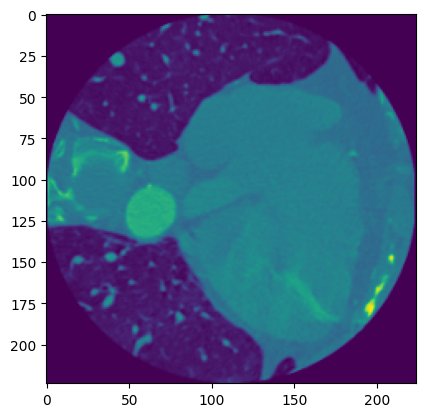

In [4]:
inp = cv2.imread("../data_for_training/MMWHS/images/heart0-slice124_axial.png", cv2.IMREAD_GRAYSCALE)
inp = cv2.resize(inp, (224, 224)).astype(np.float32) 
inp = torch.from_numpy(inp)
inp = torch.unsqueeze(inp, dim=0)
inp.shape

plt.imshow(torch.squeeze(inp))

In [5]:
# each patch is projected linearly into a dimension of 'embedding_dimension'. And the total number of patches is (H, W) of the output of convolutional layer

patch_embedding_conv = nn.Conv2d(in_channels=color_channels, out_channels=embedding_dimension, kernel_size=patch_size, stride=patch_size, padding=0) 

In [6]:
output = patch_embedding_conv(torch.unsqueeze(inp, dim=0))
output.shape 

torch.Size([1, 256, 14, 14])

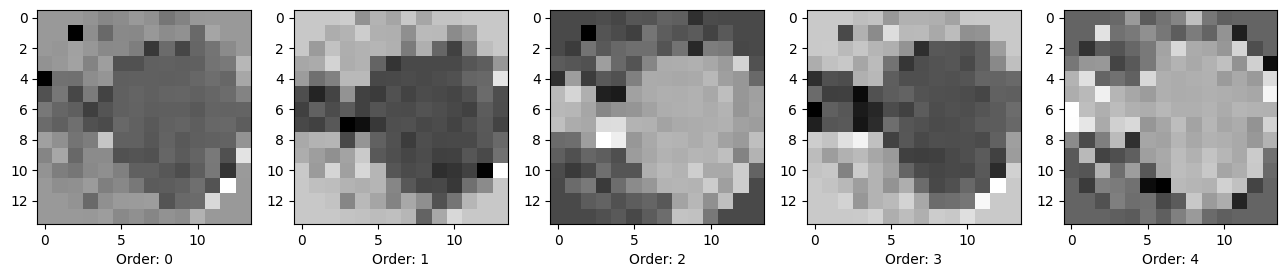

In [7]:
random_indices = np.random.randint(0, 256, size=5)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16, 16))

for i, value in enumerate(random_indices): 
    axes[i].imshow(output[0, value].detach().numpy(), cmap="gray")
    axes[i].set_xlabel(f'Order: {i}')

plt.show()

### PATCH FLATTENING

In [8]:
flatten_layer = nn.Flatten(start_dim=2, end_dim=-1) 

flattened_output =flatten_layer(output) 
print(flattened_output.shape)

torch.Size([1, 256, 196])


In [9]:
flattened_output = flattened_output.permute(0, 2, 1)
flattened_output.shape

torch.Size([1, 196, 256])

### COMBINATION 
img -> convolution: {kernel size = patch size, stride = patch size, out channels = embedding dim} -> flatten last 2 dims 

In [10]:
class PatchEmbedding(nn.Module): 
    def __init__(self, inc : int = 1, patch_size : int = 16, embedding_dim : int = 256): 
        super().__init__() 
        self.patch_size = patch_size
        self.patcher = nn.Conv2d(in_channels=inc, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size, padding=0) 
        self.flatten = nn.Flatten(start_dim=2, end_dim=-1)

    def forward(self, x): 
        image_resolution = x.shape[-1] 
        assert image_resolution  % self.patch_size == 0, f"Input image size must be divisible by patch size, image_shape: {image_resolution}, patch size: {self.patch_size}"
        
        x = self.patcher(x) 
        x = self.flatten(x) 

        return x.permute(0, 2, 1)

In [11]:
patch_embedding = PatchEmbedding() 

inp = cv2.imread(
    "../data_for_training/MMWHS/images/heart0-slice124_axial.png", cv2.IMREAD_GRAYSCALE)
inp = cv2.resize(inp, (224, 224)).astype(np.float32)
inp = torch.from_numpy(inp)
inp = torch.unsqueeze(inp, dim=0)
inp = torch.unsqueeze(inp, dim=0) 

print(f"Input image: {inp.shape}")

patch_embedded_image = patch_embedding(inp) 

print(patch_embedded_image.shape) 

Input image: torch.Size([1, 1, 224, 224])
torch.Size([1, 196, 256])


## CREATE CLASS TOKEN EMBEDDING

In [12]:
batch_size = patch_embedded_image.shape[0] 
embedding_dimension = patch_embedded_image.shape[-1]

batch_size, embedding_dimension

(1, 256)

In [13]:
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), requires_grad=True)

class_token.shape

torch.Size([1, 1, 256])

In [14]:
patch_embedded_image_class = torch.cat((class_token, patch_embedded_image), dim=1) 

patch_embedded_image_class.shape

torch.Size([1, 197, 256])

## CREATE POSITIONAL EMBEDDING

In [15]:
# num_of_patches 
positional_embedding = nn.Parameter(torch.randn(batch_size, num_of_patches + 1, embedding_dimension), requires_grad=True)
positional_embedding.shape

torch.Size([1, 197, 256])

In [16]:
# add the position embedding to embedded tensor 
patch_embedded_image_class_position = patch_embedded_image_class + positional_embedding

print(patch_embedded_image_class_position.shape)

torch.Size([1, 197, 256])


In [17]:
class MultiheadSelfAttentionBlock(nn.Module): 
    def __init__(self, embedding_dim : int = 256, num_heads : int = 16, attn_dropout : int = 0): 
        super().__init__()  

        # layer norm 
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim) 

        # multihead attention layer 
        self.multihead_attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=attn_dropout, batch_first=True)    

    def forward(self, x): 
        x = self.layer_norm(x)      
        attn_output, _ = self.multihead_attention(query=x, key=x, value=x, need_weights=False) 

        return attn_output 

In [19]:
multihead_self_attention_block  = MultiheadSelfAttentionBlock() 

patched_image_through_msa_block = multihead_self_attention_block(patch_embedded_image_class_position)

print(patched_image_through_msa_block.shape)

torch.Size([1, 197, 256])


## MULTILAYER PERCEPTRON BLOCK (MLP BLOCK)

In [20]:
class MLPBLock(nn.Module): 
    def __init__(self, embedding_dim : int = 256, mlp_size : int = 3072, dropout : int = 0.1): 
        super().__init__() 

        # create norm layer 
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim) 

        # create mlp 
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size), 
            nn.GELU(), 
            nn.Dropout(p=dropout), 
            nn.Linear(in_features=mlp_size, out_features=embedding_dim), 
            nn.Dropout(p=dropout) 
        )

    def forward(self, x): 
        x = self.layer_norm(x) 
        x = self.mlp(x) 

        return x 

In [21]:
mlp_block = MLPBLock()

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block) 

print(patched_image_through_mlp_block.shape) 

torch.Size([1, 197, 256])


## Transformer Encoder

In [23]:
class TransformerEncoderBlock(nn.Module): 
    def __init__(self, embedding_dim : int = 256, num_heads : int = 16, attn_dropout : int = 0,  mlp_size : int = 3072, mlp_dropout : int = 0.1): 
        super().__init__() 

        # multihead self attention 
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout) 

        # mlp block 
        self.mlp_block = MLPBLock(embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout)

    def forward(self, x): 
        x = self.msa_block(x) + x
        x = self.mlp_block(x)  + x 
        return x
        

In [24]:
transformer_encoder_block = TransformerEncoderBlock()

In [ ]:
torch_encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=16, dim_feedforward=3072, dropout=0.1, activaton="gelu", batch_first=True, norm_first=True)

## VIT MODEL 

In [32]:
class ViT(nn.Module): 
    def __init__(self, img_size : int = 224, 
                 inc : int = 1, 
                 patch_size : int = 16, 
                 num_transformer_layers : int = 12, 
                 embedding_dim : int = 256, 
                 mlp_size : int = 3072, 
                 num_heads : int = 16, 
                 attn_dropout : int = 0, 
                 mlp_dropout : int = 0.1, 
                 embedding_dropout : int = 0.1, 
                 num_classes : int = 8):
        
        super().__init__() 
        
        assert img_size % patch_size == 0, f"Image size must be divisble by patch size."

        # calculate number of pathces: 
        self.num_patches = (img_size * img_size) // (patch_size ** 2) 

        # create learnable class embeddings
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)

        # create learnable position embeddings 
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches + 1, embedding_dim))

        # create embeddings dropout 
        self.embedding_dropout = nn.Dropout(p=embedding_dropout) 

        # patch embedding layer 
        self.patch_embedding = PatchEmbedding(inc=inc, patch_size=patch_size, embedding_dim=embedding_dim) 

        # create transformer encoder block 
        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoderBlock(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout,  mlp_size=mlp_size, mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)]
        )

        # create classifier head 
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim), 
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )

    def forward(self, x): 
        # batch size
        batch_size = x.shape[0] 

        # expand class token embedding to match batch size 
        class_token = self.class_embedding.expand(batch_size, -1, -1) 

        # create the patch embedding
        x = self.patch_embedding(x) # -> (batch_size, num_patches, embed_dim) 

        # concat class token 
        x = torch.cat((class_token, x), dim=1)

        # add positional embedding
        x = self.position_embedding + x 

        # apply embedding dropout 
        x = self.embedding_dropout(x) 

        # pass position and patch embedding to transformer encoder 
        x = self.transformer_encoder(x) 

        # put 0th index logit through classifier 
        x = self.classifier(x[:, 0])


        return x 

In [33]:
vit = ViT()

In [35]:
x = torch.rand(1, 1, 224, 224) 

output = vit(x) 

print(output)

tensor([[-0.0127,  0.8027,  0.2553, -0.2159,  0.3769,  0.5784, -0.4698,  0.1055]],
       grad_fn=<AddmmBackward0>)


In [40]:
torchinfo.summary(model=ViT(num_classes=8), 
    input_size=(1, 1, 224, 224), 
    col_names=["input_size", "output_size", "num_params", "trainable"], 
    col_width=20, 
    row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                         [1, 1, 224, 224]     [1, 8]               50,688               True
├─PatchEmbedding (patch_embedding)                                [1, 1, 224, 224]     [1, 196, 256]        --                   True
│    └─Conv2d (patcher)                                           [1, 1, 224, 224]     [1, 256, 14, 14]     65,792               True
│    └─Flatten (flatten)                                          [1, 256, 14, 14]     [1, 256, 196]        --                   --
├─Dropout (embedding_dropout)                                     [1, 197, 256]        [1, 197, 256]        --                   --
├─Sequential (transformer_encoder)                                [1, 197, 256]        [1, 197, 256]        --                   True
│    └─TransformerEncoderBlock (0)                           